In [1]:
from pyspark import SparkContext
sc = SparkContext()

22/05/07 18:05:05 WARN Utils: Your hostname, gispi-ThinkPad-L380 resolves to a loopback address: 127.0.1.1; using 192.168.0.20 instead (on interface enxa0cec8f5b962)
22/05/07 18:05:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/07 18:05:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!head -1 201704_Usage_Bicimad.json

head: no se puede abrir '201704_Usage_Bicimad.json' para lectura: No existe el archivo o el directorio


In [3]:
import json
import datetime

In [4]:
def mapper(line):
    data = json.loads(line)
    usert = data['user_type']
    time = data['travel_time']
    date = convert_date(data['unplug_hourTime'])
    return usert, time, date

In [5]:
def convert_date(date):
    if isinstance(date, str):
        date = date.replace("Z","+0000")
        date = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z")
    else:
        date = date['$date']
        date = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f%z")
    return (date.month,date.hour)

In [6]:
convert_date({ "$date" : "2019-06-01T12:40:00.000+0200" })

(6, 12)

In [7]:
rdd_base = sc.textFile('sample_10e3.json')

In [8]:
rdd = rdd_base.map(mapper)

In [9]:
rdd.countByKey()
#0: no ha sido posible determinarlo, 1: pase anual, 2: ocasional, 3: empresa

defaultdict(int, {1: 954, 2: 10, 3: 36})

In [10]:
rdd.groupByKey()
rdd.take(10)

[(1, 219, (6, 0)),
 (1, 359, (6, 0)),
 (1, 375, (6, 0)),
 (1, 264, (6, 0)),
 (1, 367, (6, 0)),
 (1, 174, (6, 0)),
 (1, 308, (6, 0)),
 (1, 462, (6, 0)),
 (1, 482, (6, 0)),
 (1, 480, (6, 0))]

In [11]:
rdd_user1 = rdd.filter(lambda x: x[0]==1).map(lambda x: (x[1],tuple(x[2])))
rdd_user2 = rdd.filter(lambda x: x[0]==2).map(lambda x: (x[1],tuple(x[2])))
rdd_user3 = rdd.filter(lambda x: x[0]==3).map(lambda x: (x[1],tuple(x[2])))

In [12]:
rdd_user1.take(3)

[(219, (6, 0)), (359, (6, 0)), (375, (6, 0))]

In [13]:
sum(rdd_user1.map(lambda x: x[0]).take(3))

953

In [15]:
result_dict1 = rdd_user1.groupByKey().mapValues(tuple).mapValues(len).map(lambda x: (x[1],x[0])).countByKey()
result_dict2 = rdd_user2.groupByKey().mapValues(tuple).mapValues(len).map(lambda x: (x[1],x[0])).countByKey()
result_dict3 = rdd_user3.groupByKey().mapValues(tuple).mapValues(len).map(lambda x: (x[1],x[0])).countByKey()

Comprobación

In [18]:
print('total de trayectos iniciales', rdd_user1.count())
print(result_dict1)
#pequeña comprobación
total1 = 0
total2 = 0
total3 = 0 
for k,v in result_dict1.items():
    total1 += k*v
for i1,j1 in result_dict2.items():
    total2 += i1*j1
for i2,j2 in result_dict3.items():
    total3 += i2*j2
print ('total de trayectos en histograma', total1, total2, total3 )

total de trayectos iniciales 954
defaultdict(<class 'int'>, {1: 488, 2: 153, 4: 8, 3: 41, 5: 1})
total de trayectos en histograma 954 10 36


Plot

/tmp/ipykernel_9072/343407287.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


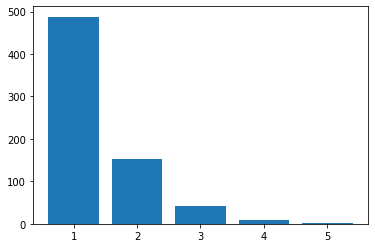

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(result_dict1.keys(),result_dict1.values())
fig.show()